In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os
import typing

from downstream import dstream
from IPython.display import display, HTML
import matplotlib as mpl
from matplotlib import ticker as mpl_ticker
import more_itertools as mit
import numpy as np
import polars as pl
import seaborn as sns
from slugify import slugify
from teeplot import teeplot as tp

import pylib  # noqa: F401


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-07-13T00:37:53.002851+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1030-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

more_itertools: 9.1.0
polars        : 1.9.0
pylib         : 0.0.0
teeplot       : 1.4.2
downstream    : 1.11.0
matplotlib    : 3.10.0
numpy         : 2.1.2
seaborn       : 0.13.2

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = False
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2025-07-06-qos-dstream-tilted"
)
teeplot_subdir


'2025-07-06-qos-dstream-tilted'

In [5]:
num_items = 10_000


## Define


In [6]:
def calc_max_qos_from_segment_lengths(segment_lengths: list[int]) -> float:
    segment_total = sum(segment_lengths)
    return max(
        (segment_length - 1) / (
            segment_total - cumulative - segment_length + 1 or 1
        )
        for cumulative, segment_length in zip(
            it.accumulate([0, *segment_lengths]),
            [*segment_lengths, 1],
        )
    )


In [7]:
def calc_mean_qos_from_segment_lengths(segment_lengths: list[int]) -> float:
    segment_total = sum(segment_lengths)
    segment_fenceposts = it.accumulate([0, *segment_lengths])
    values = []
    for begin, end in it.pairwise(segment_fenceposts):
        for rank in range(begin, end):
            depth = segment_total - rank
            assert depth
            values.append((end - begin - 1) / depth)

    values.append(0)  # fencepost

    assert len(values) ==  segment_total + 1
    assert max(values) == calc_max_qos_from_segment_lengths(segment_lengths)
    return np.mean(values)


In [8]:
def calc_max_gaps_naive_doubling_tilted(
    buffer_size: int,
    num_ingests: int,
    calc_qos: typing.Callable,
) -> list[int]:
    segment_lengths = []
    max_gaps = [0]
    for i in range(num_ingests):

        if (len(segment_lengths) == buffer_size):
            segment_lengths = [
                a + b
                for a, b in mit.batched(segment_lengths, 2)
            ]
        segment_lengths.append(1)

        assert sum(segment_lengths) == i + 1
        max_gaps.append(calc_qos(segment_lengths))

    return max_gaps[:-1]


In [9]:
def calc_max_gaps_dstream(
    buffer_size: int,
    num_items: int,
    calc_qos: typing.Callable,
) -> list[int]:
    return [
        calc_qos(
            [b - a for a, b in mit.pairwise(
            sorted(
                dstream.tilted_algo.lookup_ingest_times_eager(
                    buffer_size, i + 1
                ),
            ))],
        )
        if i >= buffer_size
        else 0
        for i in range(num_items)
    ]


In [10]:
def calc_max_gaps_zhao_tilted(
    buffer_size: int,
    num_items: int,
    calc_qos: typing.Callable,
) -> list[int]:
    segment_lengths = []
    max_gaps = [0]
    for k in range(num_items):

        segment_lengths.append(1)
        for i, j in it.pairwise(reversed(range(len(segment_lengths) - 1))):
            if segment_lengths[i] == segment_lengths[j]:
                segment_lengths[i] += segment_lengths[j]
                del segment_lengths[j]
                break

        assert sum(segment_lengths) == k + 1
        max_gaps.append(calc_qos(segment_lengths))

    return max_gaps[:-1]


In [11]:
def calc_max_gaps_zhao_tilted_full(
    buffer_size: int,
    num_items: int,
    calc_qos: typing.Callable,
) -> list[int]:
    bucket_sizes = [buffer_size, 0]
    buffer = [*range(buffer_size)]
    max_gaps = [0]


    S = buffer_size
    w = bucket_sizes
    for k in range(num_items):
        if k < S:
            assert buffer[k] == k
        else:
            bucket_sizes[0] += 1
            i = S
            j = 0
            while w[j] <= w[j + 1]:
                i -= w[j]
                j += 1
                if j == len(w) - 1:
                    w.append(0)

            assert 0 <= i <= S
            w[j] -= 2
            w[j + 1] += 1
            for n in range(i - w[j], S - 1):
                assert 0 < n < S - 1
                buffer[n] = buffer[n + 1]
            buffer[S - 1] = k

        assert buffer == sorted(buffer)
        assert sum(bucket_sizes) == buffer_size

        segment_lengths = [
            b - a for a, b in mit.pairwise(sorted(buffer))
        ]
        assert (
            sum(segment_lengths)
            == buffer_size + max(k - buffer_size + 1, 0) - 1
        )
        max_gaps.append(
            calc_qos(segment_lengths),
        )

    return max_gaps[:-1]


## Example Plot


In [12]:
def make_df(buffer_size: int) -> pl.DataFrame:
    return pl.concat(
        [
            pl.DataFrame(
                {
                    "Algorithm": "naive doubling",
                    "Gap Size Cost": calc_max_gaps_naive_doubling_tilted(
                        buffer_size,
                        num_items,
                        calc_max_qos_from_segment_lengths,
                    ),
                    "Gap Size Cost Mean": calc_max_gaps_naive_doubling_tilted(
                        buffer_size,
                        num_items,
                        calc_mean_qos_from_segment_lengths,
                    ),
                    "Num Items Ingested": range(num_items),
                },
                strict=False,
            ),
            pl.DataFrame(
                {
                    "Algorithm": "extended ringbuf",
                    "Gap Size Cost": calc_max_gaps_dstream(
                        buffer_size,
                        num_items,
                        calc_max_qos_from_segment_lengths,
                    ),
                    "Gap Size Cost Mean": calc_max_gaps_dstream(
                        buffer_size,
                        num_items,
                        calc_mean_qos_from_segment_lengths,
                    ),
                    "Num Items Ingested": range(num_items),
                },
                strict=False,
            ),
            pl.DataFrame(
                {
                    "Algorithm": "pyrimidal bucket",
                    "Gap Size Cost": calc_max_gaps_zhao_tilted(
                        buffer_size,
                        num_items,
                        calc_max_qos_from_segment_lengths,
                    ),
                    "Gap Size Cost Mean": calc_max_gaps_zhao_tilted(
                        buffer_size,
                        num_items,
                        calc_mean_qos_from_segment_lengths,
                    ),
                    "Num Items Ingested": range(num_items),
                },
                strict=False,
            ),
            pl.DataFrame(
                {
                    "Algorithm": "saturating bucket",
                    "Gap Size Cost": calc_max_gaps_zhao_tilted_full(
                        buffer_size,
                        num_items,
                        calc_max_qos_from_segment_lengths,
                    ),
                    "Gap Size Cost Mean": calc_max_gaps_zhao_tilted_full(
                        buffer_size,
                        num_items,
                        calc_mean_qos_from_segment_lengths,
                    ),
                    "Num Items Ingested": range(num_items),
                },
                strict=False,
            ),
        ]
    )


In [13]:
hue_order = [
    "extended ringbuf",
    "naive doubling",
    "saturating bucket",
    "pyrimidal bucket",
]

palette = {
    "extended ringbuf": "#9C4897",
    "naive doubling": "#828282",
    "saturating bucket": "#63a28b",
    "pyrimidal bucket": "#baf23d",
}

markers = {
    "extended ringbuf": "X",
    "naive doubling": "d",
    "saturating bucket": "d",
    "pyrimidal bucket": ".",
}

dashes = [(5, 2), (1, 0), (1, 0), (1, 1)]


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


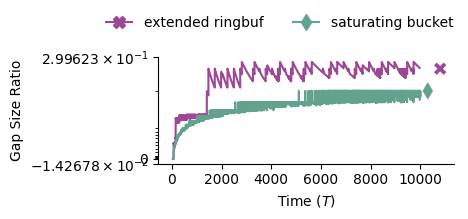

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


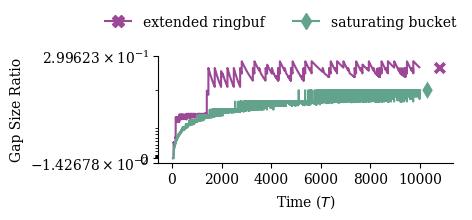

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


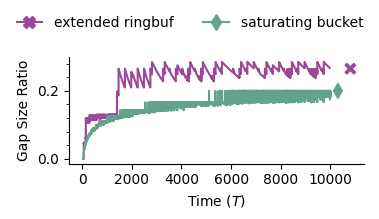

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


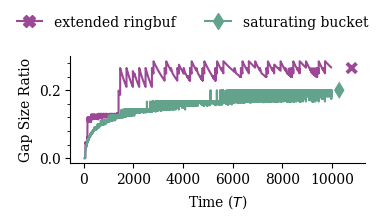

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


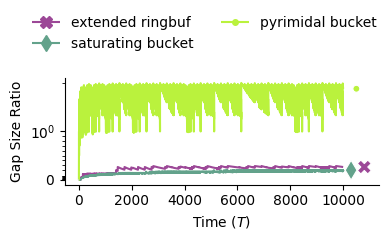

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


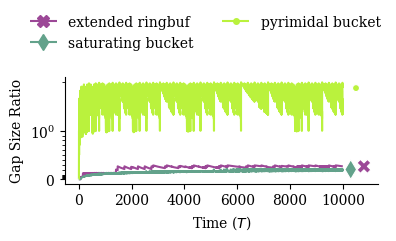

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


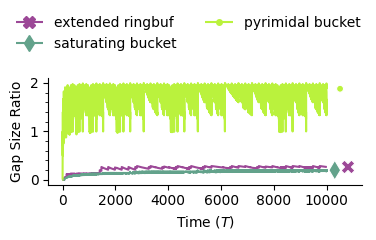

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


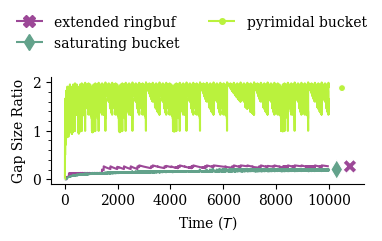

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


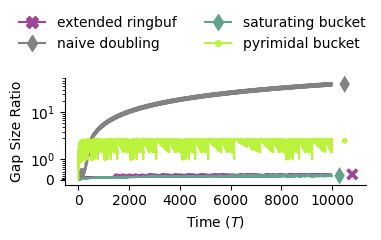

dfp['ratio'].min()=0.37
dfp['ratio'].replace(inf, nan).dropna().mean()=0.68
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


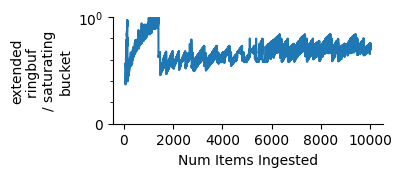

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


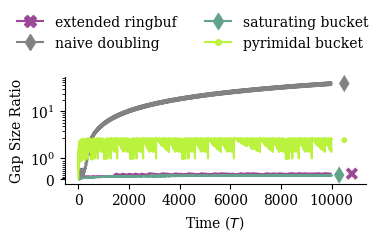

dfp['ratio'].min()=0.37
dfp['ratio'].replace(inf, nan).dropna().mean()=0.68
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


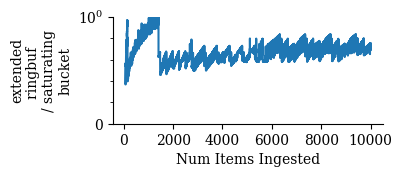

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


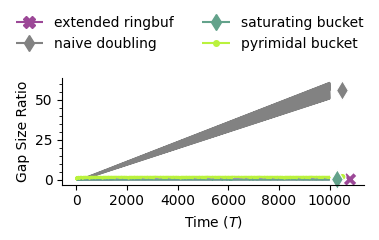

dfp['ratio'].min()=0.37
dfp['ratio'].replace(inf, nan).dropna().mean()=0.68
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


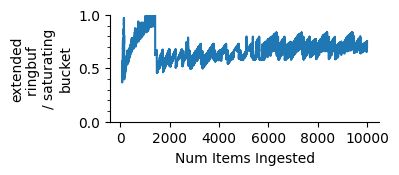

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


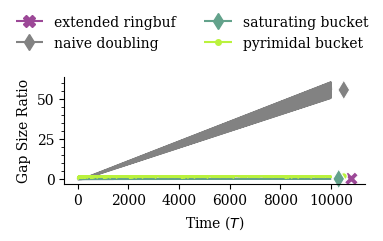

dfp['ratio'].min()=0.37
dfp['ratio'].replace(inf, nan).dropna().mean()=0.68
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


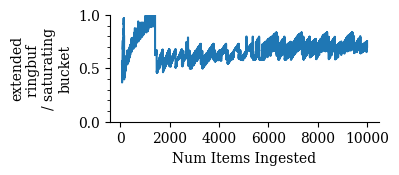

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


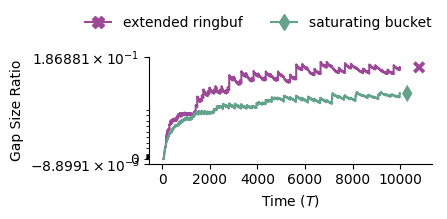

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


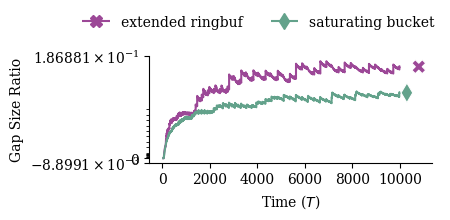

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


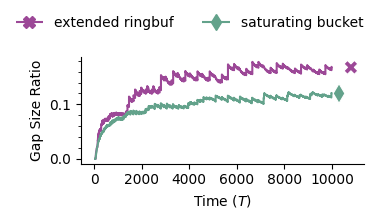

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


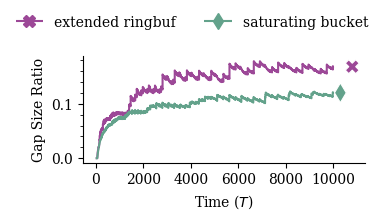

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


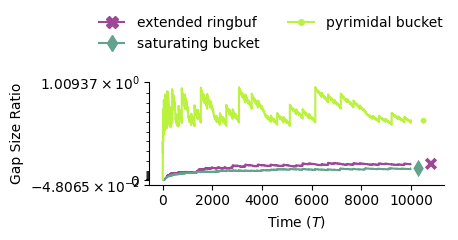

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


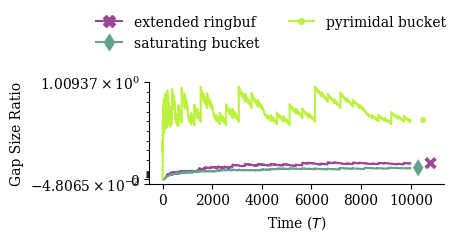

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


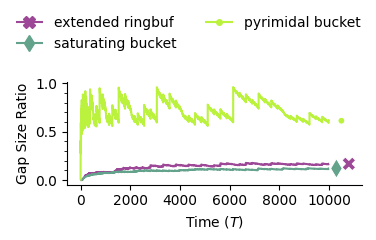

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


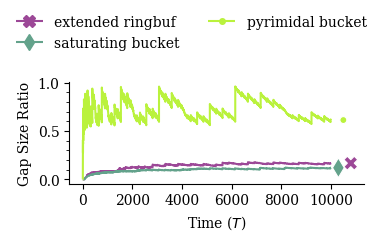

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


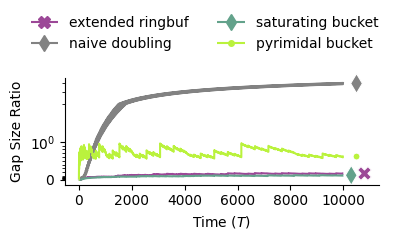

dfp['ratio'].min()=0.59
dfp['ratio'].replace(inf, nan).dropna().mean()=0.72
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


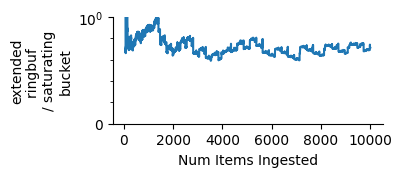

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


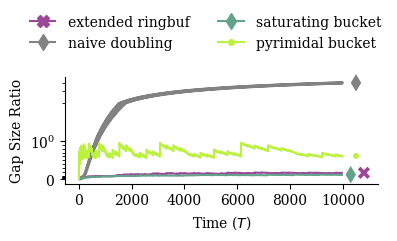

dfp['ratio'].min()=0.59
dfp['ratio'].replace(inf, nan).dropna().mean()=0.72
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


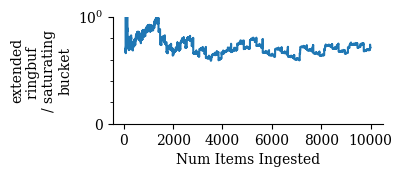

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


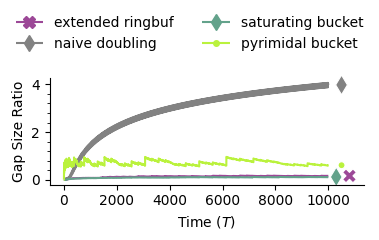

dfp['ratio'].min()=0.59
dfp['ratio'].replace(inf, nan).dropna().mean()=0.72
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


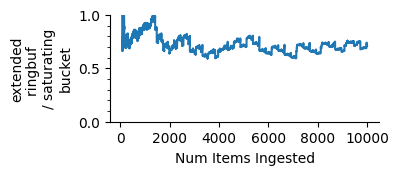

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


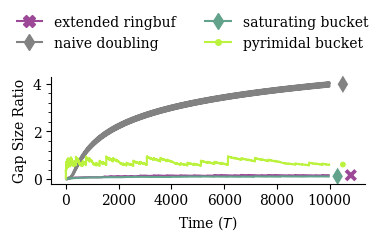

dfp['ratio'].min()=0.59
dfp['ratio'].replace(inf, nan).dropna().mean()=0.72
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=64+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


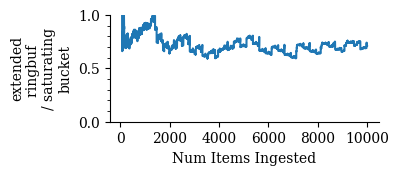

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


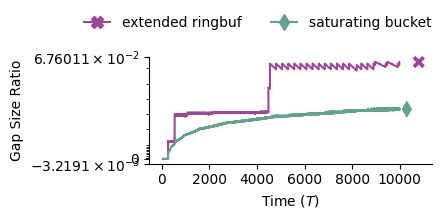

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


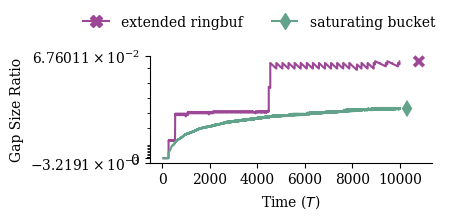

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


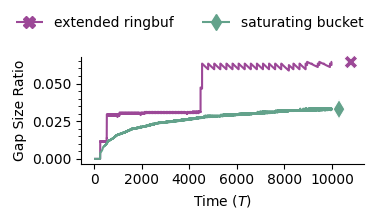

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


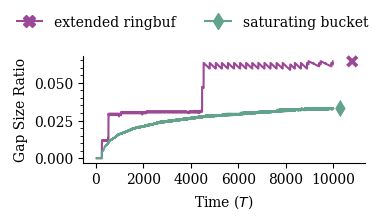

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


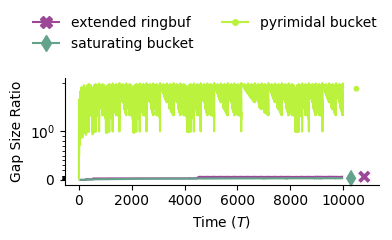

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


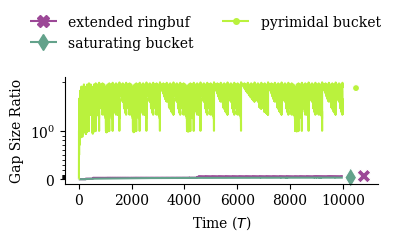

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


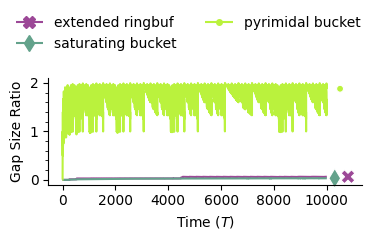

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


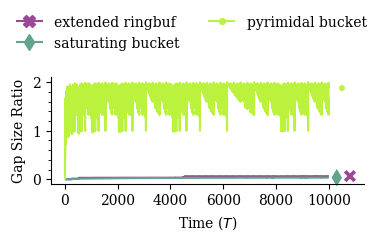

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


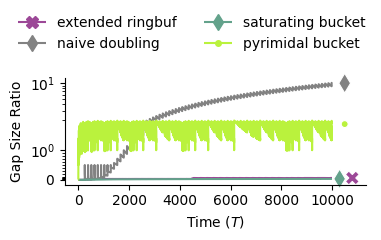

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.59
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


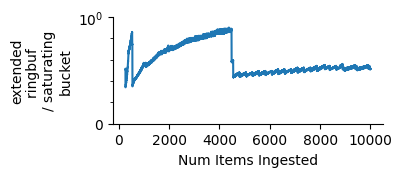

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


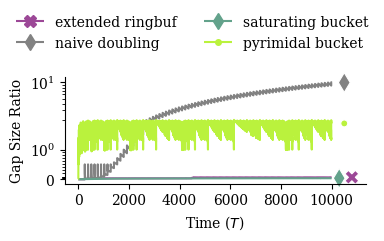

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.59
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


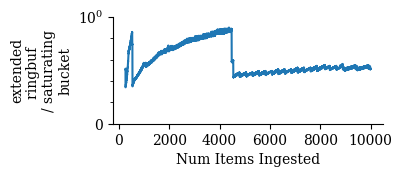

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


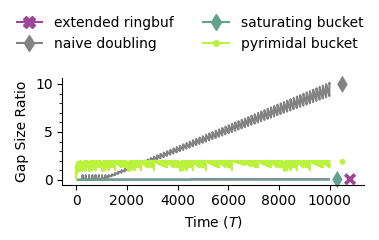

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.59
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


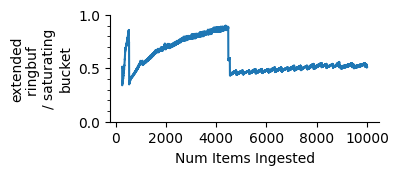

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


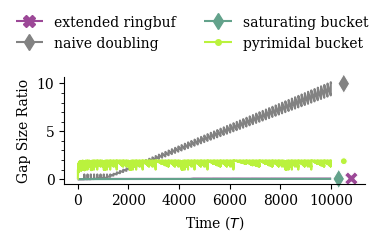

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.59
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


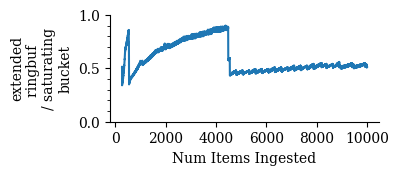

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


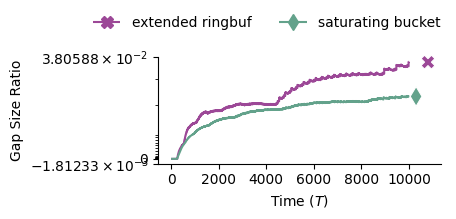

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


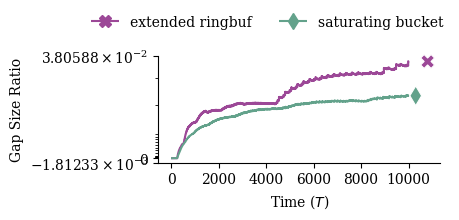

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


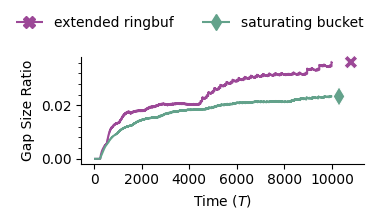

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


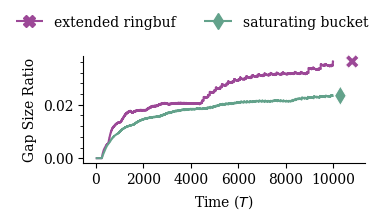

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


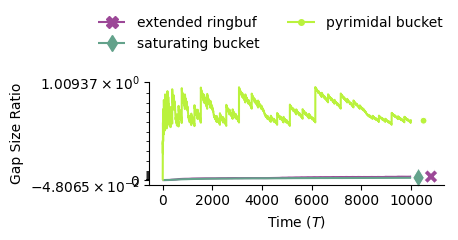

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


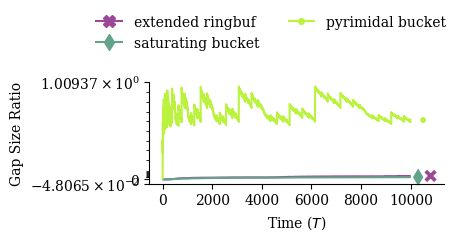

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


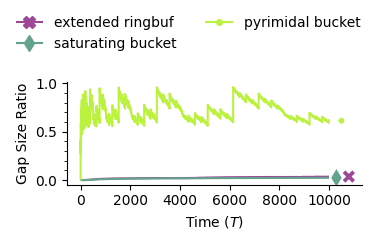

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


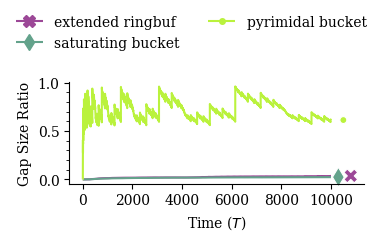

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


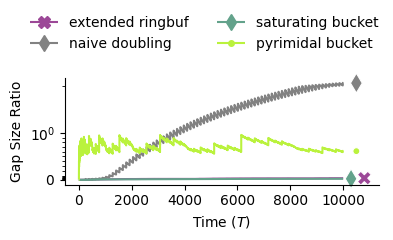

dfp['ratio'].min()=0.58
dfp['ratio'].replace(inf, nan).dropna().mean()=0.75
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


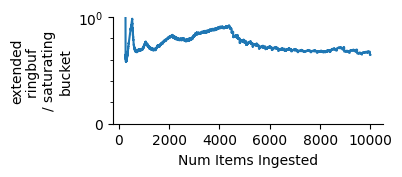

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


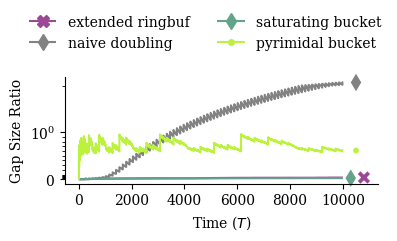

dfp['ratio'].min()=0.58
dfp['ratio'].replace(inf, nan).dropna().mean()=0.75
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


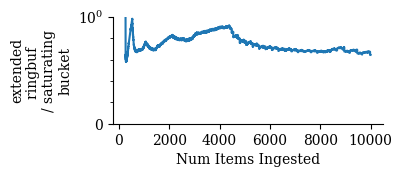

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


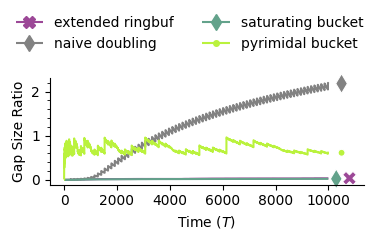

dfp['ratio'].min()=0.58
dfp['ratio'].replace(inf, nan).dropna().mean()=0.75
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


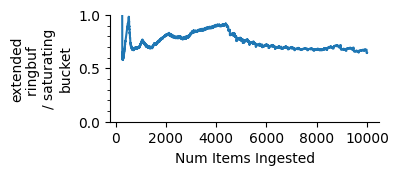

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


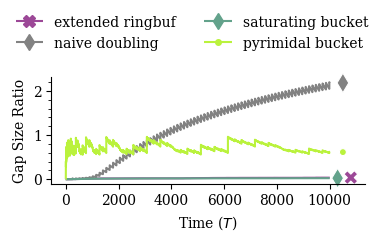

dfp['ratio'].min()=0.58
dfp['ratio'].replace(inf, nan).dropna().mean()=0.75
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=256+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


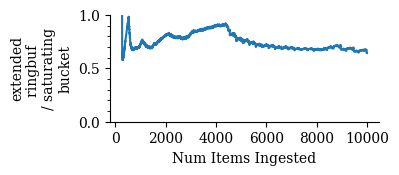

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


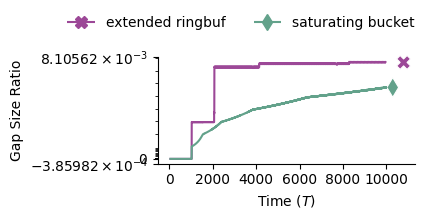

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


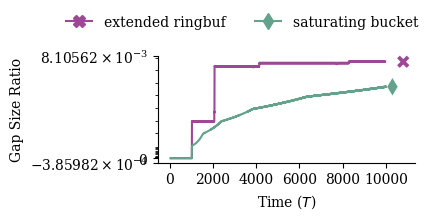

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


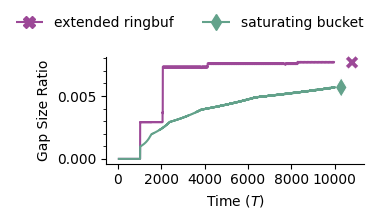

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


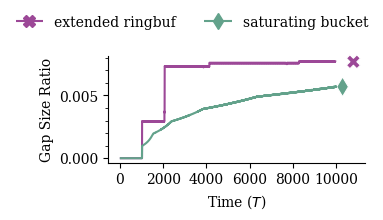

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


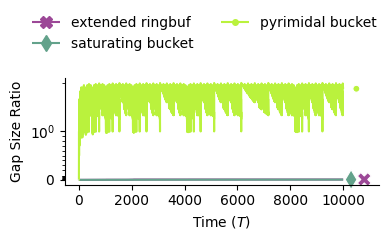

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


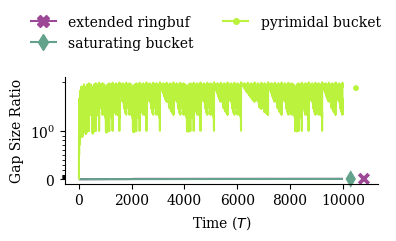

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


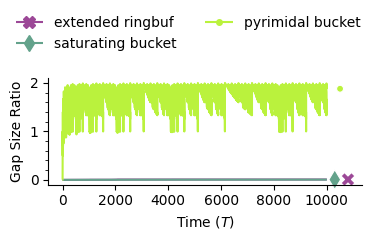

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


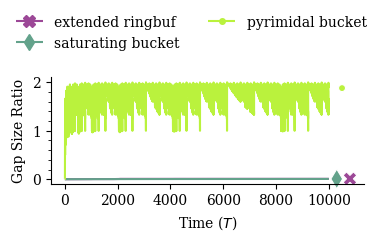

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


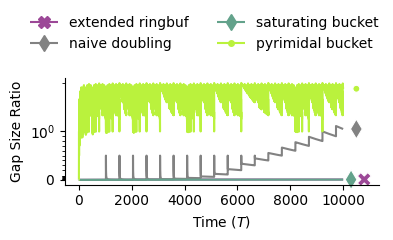

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.60
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


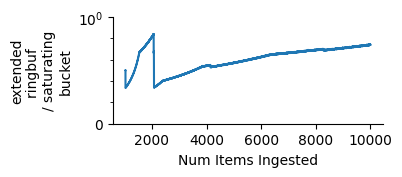

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=symlog+ext=.png


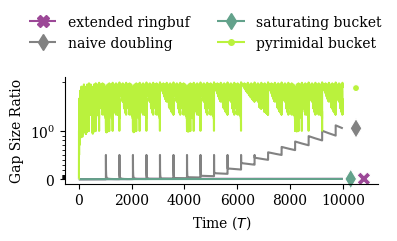

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.60
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


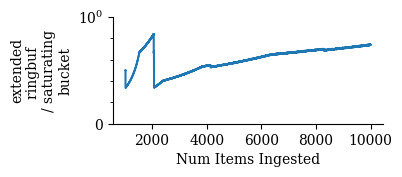

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


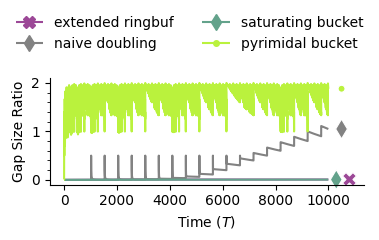

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.60
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


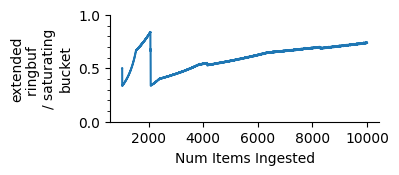

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost+yscale=linear+ext=.png


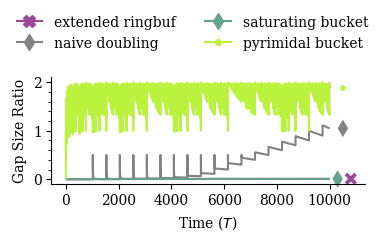

dfp['ratio'].min()=0.34
dfp['ratio'].replace(inf, nan).dropna().mean()=0.60
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


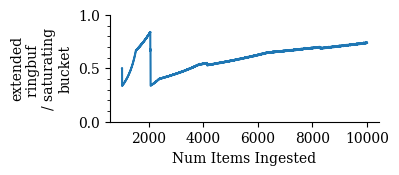

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


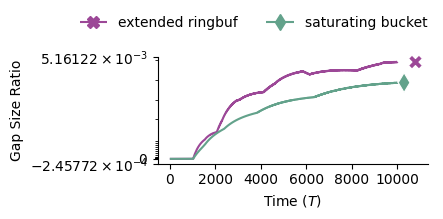

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


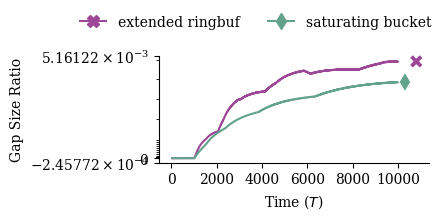

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


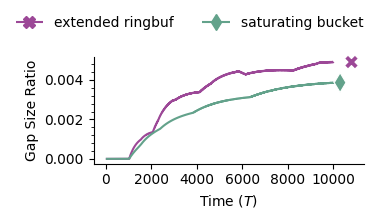

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling-pyrimidal-bucket+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


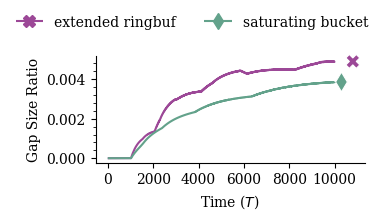

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


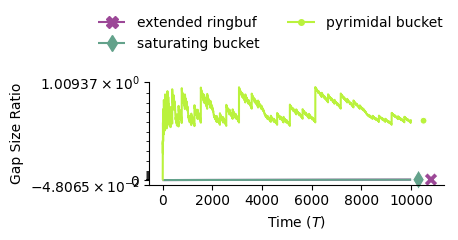

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


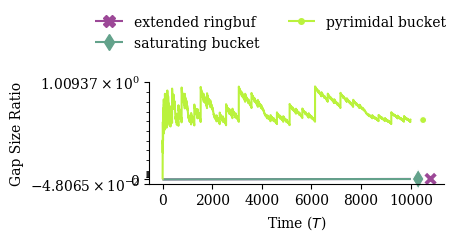

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


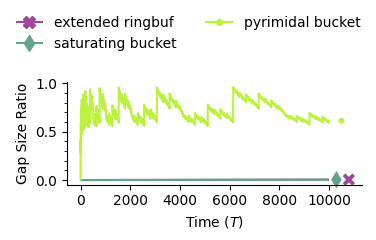

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=naive-doubling+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


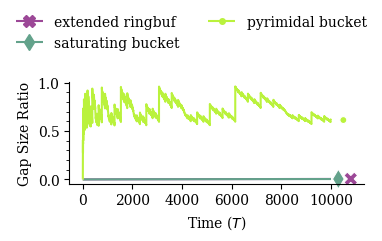

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


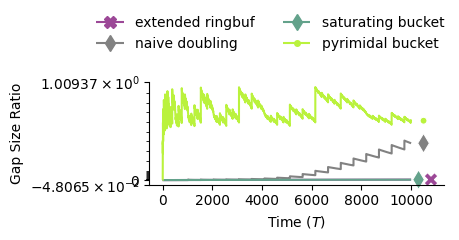

dfp['ratio'].min()=0.54
dfp['ratio'].replace(inf, nan).dropna().mean()=0.74
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


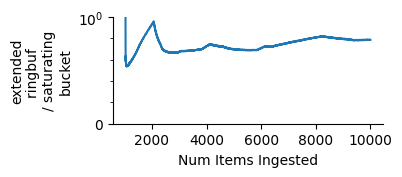

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=symlog+ext=.png


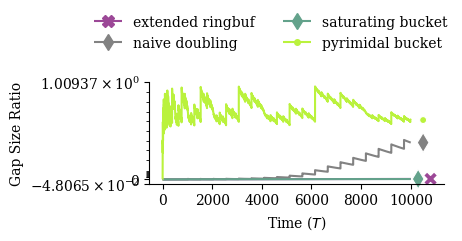

dfp['ratio'].min()=0.54
dfp['ratio'].replace(inf, nan).dropna().mean()=0.74
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=symlog+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


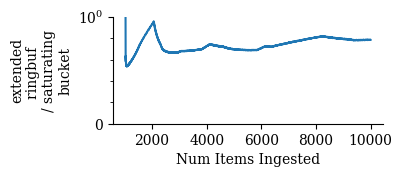

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


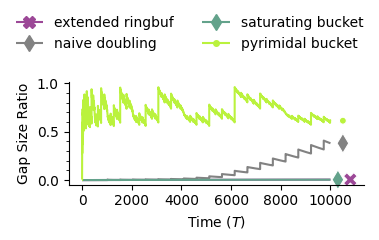

dfp['ratio'].min()=0.54
dfp['ratio'].replace(inf, nan).dropna().mean()=0.74
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


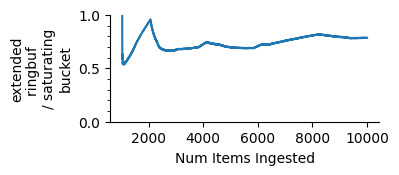

teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+excl=+font.family=serif+hue=algorithm+kind=line+style=algorithm+viz=relplot+x=num-items-ingested+y=gap-size-cost-mean+yscale=linear+ext=.png


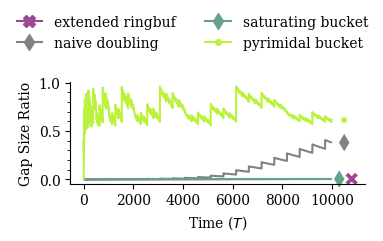

dfp['ratio'].min()=0.54
dfp['ratio'].replace(inf, nan).dropna().mean()=0.74
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.pdf
teeplots/2025-07-06-qos-dstream-tilted/buffer_size=1024+font.family=serif+kind=line+palette=set2+viz=relplot+what=gap-size-cost-mean+x=num-items-ingested+y=ratio+yscale=linear+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


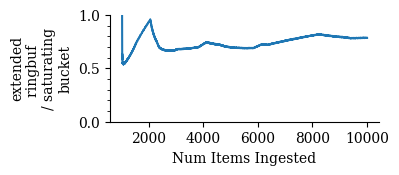

In [14]:
for buffer_size in [64, 256, 1024]:
    df = make_df(buffer_size)
    for what, excl, yscale in it.product(
        ["Gap Size Cost", "Gap Size Cost Mean"],
        [["naive doubling", "pyrimidal bucket"], ["naive doubling"], []],
        ["symlog", "linear"],
    ):
        display(HTML(f"<h2>{what}</h2>"))
        ho = [x for x in hue_order if x not in excl]

        for rc in [{}, {"font.family": "serif"}]:
            with mpl.rc_context(rc=rc):
                with tp.teed(
                    sns.relplot,
                    df.filter(
                        ~pl.col("Algorithm").is_in(excl),
                    ),
                    x="Num Items Ingested",
                    y=what,
                    hue="Algorithm",
                    hue_order=ho,
                    style_order=ho,
                    style="Algorithm",
                    markers=markers,
                    aspect=2.2,
                    dashes=[(1, 0)] * 4,
                    kind="line",
                    markersize=0,
                    height=1.8,
                    palette=palette,
                    teeplot_outattrs={
                        "buffer_size": buffer_size,
                        "excl": "-".join(map(slugify, excl)),
                        "yscale": yscale,
                        **rc,
                    },
                    teeplot_subdir=teeplot_subdir,
                ) as g:
                    sns.move_legend(
                        g,
                        "lower center",
                        bbox_to_anchor=(0.38, 1),
                        ncol=2,
                        title=None,
                        frameon=False,
                    )
                    g.set(ylabel="Gap Size Ratio", xlabel="Time ($T$)")
                    g.set(yscale=yscale)
                    sns.scatterplot(
                        data=df.filter(
                            ~pl.col("Algorithm").is_in(excl),
                        ).filter(
                            pl.col("Num Items Ingested")
                            == pl.col("Num Items Ingested").max(),
                        ).with_columns(
                            pl.col("Num Items Ingested") * pl.when(
                                pl.col("Algorithm") == "extended ringbuf"
                            ).then(1.08).when(
                                pl.col("Algorithm") == "saturating bucket"
                            ).then(1.03).otherwise(1.05),
                        ),
                        x="Num Items Ingested",
                        y=what,
                        hue="Algorithm",
                        hue_order=ho,
                        style="Algorithm",
                        style_order=ho,
                        markers=markers,
                        s=100,
                        palette=palette,
                        legend=False,
                        ax=g.axes.flat[0],
                        clip_on=False,
                    )
                    g.axes.flat[0].yaxis.set_minor_locator(
                        {
                            "symlog": mpl_ticker.LogLocator(
                                numticks=999, subs="auto"
                            ),
                            "linear": mpl_ticker.AutoMinorLocator(5),
                        }[yscale]
                    )
                    for handle in g._legend.legend_handles:
                        handle.set_markersize(8)

                if not excl:
                    dfp = df.filter(
                            ~pl.col("Algorithm").is_in(excl),
                        ).pivot(
                        index="Num Items Ingested",
                        on="Algorithm",
                        values=what,
                    ).to_pandas()
                    dfp["ratio"] = (
                        dfp["saturating bucket"] / dfp["extended ringbuf"]
                    )
                    inf, nan = np.inf, np.nan
                    print(
                        f"{dfp['ratio'].min()=:.2f}",
                        f"{dfp['ratio'].replace(inf, nan).dropna().mean()=:.2f}",
                        sep="\n",
                    )
                    with tp.teed(
                        sns.relplot,
                        dfp,
                        x="Num Items Ingested",
                        y="ratio",
                        aspect=2.0,
                        kind="line",
                        height=1.8,
                        palette="Set2",
                        teeplot_outattrs={
                            "buffer_size": buffer_size,
                            "what": slugify(what),
                            "yscale": yscale,
                            **rc,
                        },
                        teeplot_subdir=teeplot_subdir,
                    ) as g:
                        g.set(ylim=(0, 1), yscale=yscale)
                        g.set(
                            ylabel="extended\nringbuf \n/ saturating\nbucket",
                        )
                        g.axes.flat[0].yaxis.set_minor_locator(
                            mpl_ticker.AutoMinorLocator(5),
                        )
